# TM

Temamodellering basert på clustring, klikk og grafanalyse.

Her ser vi på 
1. Bygg et korpus
1. Hvordan hente ut tematiske strukturer fra korpus
1. Hvordan evaluere temaer mot et større korpus

Om de tematisk strukturene kommer et annetsteds fra, så kan evalueringen fremdeles benyttes, og evalueres mot bokhyllas data.


### først litt kode for å komme i gang

In [1]:
import json
import pandas as pd
import dhlab.module_update as mu
mu.update('mods_meta')
import mods_meta as mm
import dhlab.nbtext as nb
import re
from IPython.display import Markdown, display
from collections import Counter
from dhlab.nbtokenizer import tokenize
import networkx as nx
import dhlab.graph_networkx_louvain as gnl
import datetime
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import json
mu.update('wordbank')

Updated file `C:\Users\yoons\Documents\GitHub\Trawling\mods_meta.py`

Updated file `C:\Users\yoons\Documents\GitHub\Trawling\wordbank.py`

In [2]:
from wordbank import word_paradigm_many, word_lemma_many, word_form_many

In [3]:
mu.css( )

Set fontsizes for plots etc.

In [4]:
from nb_api_kollokasjon_konk import *

Updated file `C:\Users\yoons\Documents\GitHub\Trawling\mods_meta.py`

Updated file `C:\Users\yoons\Documents\GitHub\Trawling\collocations.py`

In [5]:
def declensions(wordbagfamily, pos = None):
    """Set pos to subst, verb or adj for limiting the inflectional forms"""
    if isinstance(pos, list):
        res = {key: list(set([w for infl_set in word_para(wordbagfamily[key]) for w in infl_set[2] if infl_set [1] in pos])) for key in wordbagfamily}
    elif isinstance( pos, str):
        res = {key: list(set([w for infl_set in word_para(wordbagfamily[key]) for w in infl_set[2] if infl_set [1] == pos])) for key in wordbagfamily}
    else:
        res = {key: list(set([w for infl_set in word_para(wordbagfamily[key]) for w in infl_set[2]])) for key in wordbagfamily}
    return res
    
    

In [6]:
def word_para(ws):
    res = word_paradigm_many(ws)
    for w in ws:
        if w not in [x[0] for x in res]:
            res.append([w, 'subs', [w]])
    return res

In [7]:
word_para(['Arbeidere', 'idretten'])

[['idretten', 'subs', ['idrett', 'idretten', 'idrettene', 'idretter']],
 ['Arbeidere', 'subs', ['Arbeidere']]]

# Analyse

### Sammenligning 

Det kan være greit å ha en samling ord for utvalg av et sett ord fra korpuset. Om vi satser på en standard forskjellsanalyse, tar vi utgangspunkt i de 200 000 mest frekvente ordene i bokhylla. Tallet kan økes. 

In [8]:
tot = nb.frame(nb.totals(200000), 'tot')

In [9]:
nb.normalize_corpus_dataframe(tot)

True

### Korpus

Bygg et korpus på en eller annen måte. Her ser vi på 10 bøker hentet fra en bestemt periode, markert med emneordet 'krig'.

In [10]:
books = nb.book_corpus(subject = 'krig', lang= 'nob', period = (1990, 2010))

En kjapp oversikt over titler og forfatter.

In [11]:
books

,urn,author,title,year
0,2013043007009,"Bakkeli, Tom",Norges hemmelige krigere,2007
1,2015052148026,"Murray, Stuart",Vietnamkrigen,2006
2,2013012306037,"Skjønsberg, Harald",Forliset,1994
3,2010050408113,"Varmer, Hjørdis",ondeste dagen,1996
4,2011011903024,"Leliënhof, Marcel",Fred,2006
5,2012101205010,"Larsen, Rolf-Petter",Ledelse og mestring i krig og fred,2000
6,2011071805516,"Quṭb, Sayyid",Milepæler,2004
7,2011083105002,"Holm, Terje H.",Ærens mark,2004
8,2011031005018,"Kove, Torill",Min bestemor strøk kongens skjorter,2000
9,2008022204004,"Lund, Atla",Aldri gi opp håpet,1995


For å analysere samforekomster, telles ordene. Korpuset her tilsvarer subcorpus i Tangherlini&Leonard. Desto mindre jo bedre. Ordfrekvensene normaliseres i samme rennet.

In [12]:
df = nb.frame(nb.aggregate_urns(list(books.urn)))
nb.normalize_corpus_dataframe(df)

True

Når ordene sammenlignes med det som er forventet dukker det opp en slags tematisk struktur, som vi ser i neste output. Ordene er toppordene for de som utgjør en forskjell på korpuset sammenlignet med resten av bokhylla. Men merk at enkelte bøker kan dominere her, så derfor lurt å minske antallet, eller analysere bøkene en for en. 

Vi bruker korpus-ordene for å lage en tematisk struktur. Alt vi vet foreløpig er at hver og en av dem forekommer hyppigere i korpuset enn ellers i bokverdenen. Hvordan henger de sammen?

In [13]:
list(nb.frame_sort(nb.frame(df[0]/tot.tot)).head(20).index)

['Momo',
 'kroatene',
 'Kaka',
 'meglerne',
 'KONGE',
 'Stoltenberg',
 'Nussbaum',
 'Winnie',
 'bosniske',
 'serberne',
 'Mønnesland',
 'al-Qaida',
 'Stoltenbergs',
 'Taliban',
 'levesettet',
 'NFS',
 'Milosevic',
 'Croatia',
 'Bosnia',
 'fredsprosessen']

In [14]:
selection = word_form_many(list(nb.frame_sort(nb.frame(df[0]/tot.tot)).head(5000).index))

In [15]:
selection = [x for x in selection if 'subs' in x[1] or 'verb' in x[1]]

In [16]:
len(selection)

2689

Ordene over kan vi bruke til å konstruere en graf basert på samforekomster. Kommandoen `nb.make_network_graph` tar en liste med ord og strukturer dem basert på samforekomst. Et ord W er koblet med en bue til et annet ord V, hvis W og V opptrer i samme avsnitt. Det gir en grafstruktur som kan visualiseres og analyseres.

Her ser vi bare på ord som er mer eller mindre unike for tekstene i korpuset. Antallet ord bestemmes av parametret for `head()` i koden under. Her er den satt til 300, andre verdier gir flere ord, som vil øke størrels og antall på temaer.

Ordene som skal brukes kunne i prinsippert vært hele korpuset, men for å komme i havn før nyttårsaften, og ikke sprenge datakapasiteten gjøres et utvalg. Forskjellig sett ord kan velges og gi andre resultat.

In [17]:
Gs = [nb.make_network_graph(str(u), [x[0] for x in selection]) for u in books.urn]

In [18]:
G = nx.Graph()
for g in Gs:
    G.add_edges_from(g.edges(data=True))

Grafen ser sånn ut. Med fargelagte noder for clustertilhørighet.

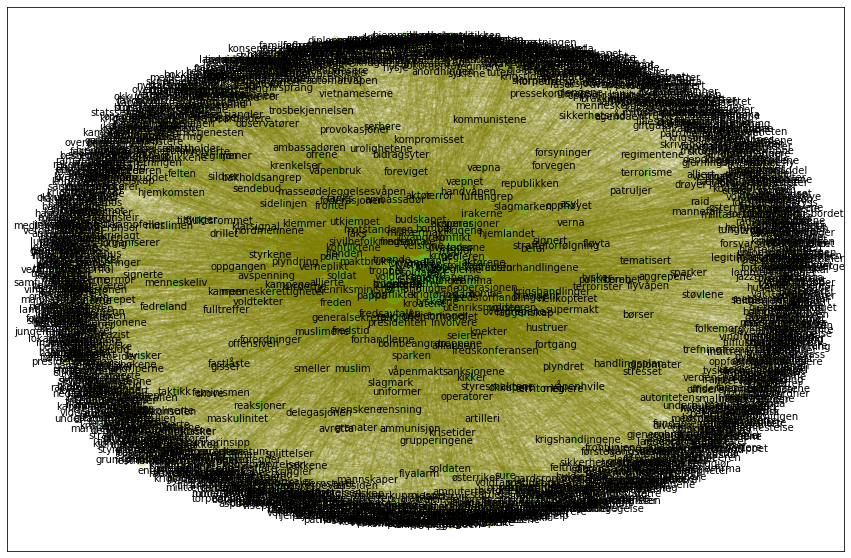

In [19]:
gnl.show_graph(G, spread = 1.5)

Nedenfor kan vi se på clustrene generert fra grafen (Louvain-metoden), som til syvende og sist er antatt å definere et aspekt ved den tematiske strukturen for korpuset. Tematikken er her basert på de viktigste ordene, beskrevet ovenfor. Andre detaljer vil komme frem ved å bruke andre ord som input, ordsekker laget ved kollokasjon for eksempel.

En mulig svakhet ved clustringsalgoritmer er at de partisjonerer ordene, sånn at ord ikke forekommer i to eller fler clustre, til forskjell fra mixtur-modeller som LDA og NMF. Klikkstrukturene er bedre i så henseende. Vi bruker dem ikke nå i første omgang men se artikkelen om forskjellen på klikk og clustring ["Graph Analysis of Word Networks”](http://ceur-ws.org/Vol-2021/paper6.pdf)..

Merkelappen på clustrene er hentet fra de mest sentrale ordene i clustret. Og hjelper litt med en begrepsmessig orden.

In [20]:
gnl.show_communities(G)

våpen-angrep :  våpen, angrep, tropper, allierte, styrkene, svenskene, operasjonen, troppene, kampene, nordmennene, operasjonene, operasjon, beleiringen, offiserer, operatorene, kamper, ammunisjon, gisler, felttoget, kommunistene, sagnet, danskene, terrorister, festningen, offensiven, bombe, krigere, forsyninger, plyndring, bombeangrep, alliert, nederlaget, offensiv, helikoptre, armeen, aksjoner, okkuperte, opererte, bomber, artilleri, frigjøringen, motparten, beskutt, mannskaper, uniformer, tjenestegjorde, helikopteret, invasjonen, allmuen, etterretning, stattholder, stresset, bakhold, helikopter, bombet, masseødeleggelsesvåpen, bombefly, mannskapene, klarsignal, tåpene, miner, svensker, regimentene, bombene, gjenerobret, flyalarmen, krutt, handvåpen, generalene, unnsetning, granater, kapitulerte, personellet, tanks, oppdragene, folkerett, skauen, åtak, troppen, marsjerer, nedkjempet, festningene, jegerne, gislene, posisjonene, fedrelandet, angriperne, faner, regimenter, hevnet, festn

### Evaluering, tråling

Temaene generert over kan analyseres på selve korpuset, eller på et annet større korpus. Først ser vi på selve korpust

Temaene hentes ut som en familie ordklasser

In [21]:
themes = gnl.community_dict(G)

For å få med bøyningsvarianter, legger vi til infleksjonsformer for ord som har det.

In [22]:
themes_plus = declensions(themes)

### Gå gjennom bøker og tell opp temaene

In [23]:
evals = nb.wordbag_eval(themes_plus, list(books.urn)).astype(int)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
evals.style.background_gradient(axis = 0)

### Evaluere mot et skjønnlitterært korpus fra samme era.

Evalueringen er uavhengig av hvordan temaordene er laget. De kan lages for hånd, genereres med LDA, eller som over, hentet fra grafer. Evalueringen teller opp ordsekkfamilien over et sett ord.

In [ ]:
testkorpus = nb.book_corpus(ddk = '839%', period = (1990, 2010), limit = 20000)

In [ ]:
testeval = nb.wordbag_eval(themes_plus, list(testkorpus.urn)).astype(int)

Korpuset er litt for stort til visualisering, så sorterer på et trekk og tar ut de 50 beste

In [ ]:
testeval.sort_values(by = 'snitt', ascending = False).head(50).style.background_gradient(axis = 0)